In [1]:
#Standard imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#wfdb and ast are used to import the libraries. neurokit2 is what we use for processing biosignals
import wfdb
from wfdb import processing
import ecg_plot
import ast
import neurokit2 as nk

#The following libraries are used for signal processing. multipletests is needed for the Bonferonni correction
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.sandbox.stats.multicomp import multipletests

#For signal manipulation and fast fourier transform
import scipy.signal as signal
from scipy.fftpack import fft

#pywt refers to PyWavelet. Used to get Discrete Wavelet Transforms
import pywt

#For multiple ad-fuller tests
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

## Section 2: Loading the data and EDA

This notebook looks into the ecg data, taking one ecg sample of 10 seconds as an example. Stationarity is calculated, and the amplitudes of the ecgs are visualised as well. The ecg signal is also viewed in the frequency domain, and morphological features like P waves are found. Finally, a summary of heart rate variability is found for all 12 leads.

This notebook is split into several parts.

1. [Loading the raw data](#part-2-1-loading-the-raw-data)
2. [Exploring the meta data](#part-2-2-1-exploring-the-meta-data)
 1. [Decomposing the ecg data](#part-2-2-2-1-decomposing-the-ecg-data)
 2. [Calculating Stationarity](#part-2-2-2-2-calculating-stationarity)
 3. [Finding the amplitude of the ecg](#part-2-2-2-3-finding-the-amplitude-of-the-ecgs)
 4. [Visualising the ecg signal in the frequency domain](#part-2-2-2-4-visualising-the-ecg-signal-in-the-frequency-domain)
 5. [Visualising the P wave, QRS complex, T wave, and RR peaks of a typical ecg](#part-2-2-2-5-visualising-the-p-wave-qrs-complex-t-wave-and-rr-peaks-of-a-typical-ecg)
 6. [Getting heart rate variability](#part-2-2-2-6-getting-heart-rate-variability)

<a id=part-2-1-loading-the-raw-data></a>

### Part 2.1: Loading the raw data

Load the raw data. The below cell has been taken from the example script in the PTB-XL dataset to load the data.

In [2]:
#Load raw_signals in array format
raw_signals = np.load('../data/data_analysis_files/ptb_raw_signals.npz')
raw_signals = raw_signals['arr_0']

In [3]:
raw_signals[0:1]

array([[[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
        [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
        [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
        ...,
        [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
        [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
        [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]]],
      dtype=float16)

In [4]:
#Load raw_signals that were converted to dataframe
signals_df = pd.read_csv('../data/data_analysis_files/ptb_signals_df.csv.gz', compression='gzip')

In [5]:
signals_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058


In [6]:
signals_df.shape

(21837000, 12)

In [7]:
signals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21837000 entries, 0 to 21836999
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
dtypes: float64(12)
memory usage: 2.0 GB


In [8]:
signals_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,2.183700e+07,2.183700e+07,2.183700e+07,2.183700e+07,2.183700e+07,2.183700e+07,2.183700e+07,2.183700e+07,2.183700e+07,2.183700e+07,2.183700e+07,2.183700e+07
mean,-1.845856e-03,-1.302771e-03,5.432910e-04,1.555459e-03,-1.143790e-03,-3.564934e-04,1.703134e-04,-9.131268e-04,-1.488353e-03,-1.746866e-03,-7.707096e-04,-2.074064e-03
std,1.640100e-01,1.647168e-01,1.712896e-01,1.403083e-01,1.460696e-01,1.465611e-01,2.337413e-01,3.376723e-01,3.336281e-01,3.058301e-01,2.731171e-01,2.755435e-01
min,-7.455000e+00,-5.856000e+00,-4.656000e+00,-3.679000e+00,-7.473000e+00,-5.300000e+00,-1.782500e+01,-1.110200e+01,-1.632000e+01,-1.119800e+01,-1.305500e+01,-2.003200e+01
25%,-6.300000e-02,-6.800000e-02,-4.000000e-02,-2.600000e-02,-4.800000e-02,-4.800000e-02,-2.400000e-02,-6.500000e-02,-8.700000e-02,-9.500000e-02,-9.000000e-02,-7.900000e-02
50%,-2.500000e-02,-2.200000e-02,6.000000e-03,2.400000e-02,-1.400000e-02,-6.000000e-03,2.100000e-02,0.000000e+00,-1.900000e-02,-3.300000e-02,-3.700000e-02,-3.200000e-02
75%,2.100000e-02,4.100000e-02,5.100000e-02,6.100000e-02,2.400000e-02,4.000000e-02,6.500000e-02,8.900000e-02,7.800000e-02,5.000000e-02,3.200000e-02,2.800000e-02
max,4.398000e+00,5.576000e+00,7.491000e+00,5.920000e+00,4.425000e+00,5.553000e+00,1.054700e+01,1.215700e+01,8.505000e+00,8.696000e+00,1.721200e+01,1.296600e+01


In [9]:
#Set path and sampling rate
path = '../data/ptb_xl/'
sampling_rate=100

# load and convert annotation data
meta_data_df = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
meta_data_df.scp_codes = meta_data_df.scp_codes.apply(lambda x: ast.literal_eval(x))

In [10]:
# Load scp_statements.csv for diagnostic aggregation, i.e. reduce diagnostic classes to 6 superclasses
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
meta_data_df['diagnostic_superclass'] = meta_data_df.scp_codes.apply(aggregate_diagnostic)

Let's check the meta_data_df's diagnostic superclass

In [11]:
meta_data_df['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21837, dtype: object

It seems to be a list

In [12]:
#Convert the list to a string. While running this, I ran into errors. There seems to have been empty strings
#With no diagnoses. So convert empty lists to 'NO_DIAG', for no diagnosis
for i in range(1,len(meta_data_df['diagnostic_superclass'])+1):
    try:
        meta_data_df['diagnostic_superclass'][i] = meta_data_df['diagnostic_superclass'][i][0]
    except:
        meta_data_df['diagnostic_superclass'][i] = 'NO_DIAG'

<ipython-input-12-ad8a7d45a2ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data_df['diagnostic_superclass'][i] = meta_data_df['diagnostic_superclass'][i][0]
<ipython-input-12-ad8a7d45a2ad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data_df['diagnostic_superclass'][i] = 'NO_DIAG'


In [13]:
meta_data_df['diagnostic_superclass']

ecg_id
1        NORM
2        NORM
3        NORM
4        NORM
5        NORM
         ... 
21833    STTC
21834    NORM
21835    STTC
21836    NORM
21837    NORM
Name: diagnostic_superclass, Length: 21837, dtype: object

How do our raw signals look like?

In [14]:
raw_signals.shape

(21837, 1000, 12)

There are 21837 rows of data...

...Each of 10 seconds (represented by 1000)...

...measuring the 12 leads of the 12-lead ecg (i.e. 12 variables)

Let's take a look at the data

In [15]:
raw_signals[21836][999]

array([ 0.166, -0.007, -0.173, -0.08 ,  0.17 , -0.09 ,  0.069,  0.291,
        0.178,  0.106,  0.047, -0.103], dtype=float16)

raw_signals [21836] [999] refers to ecg number 21836 (the last one), on the 999th time period (10th second). The 12 float64s refers to the values of each lead of the 12-lead ecg.

Let's take a look at how one of these ecg plots look like

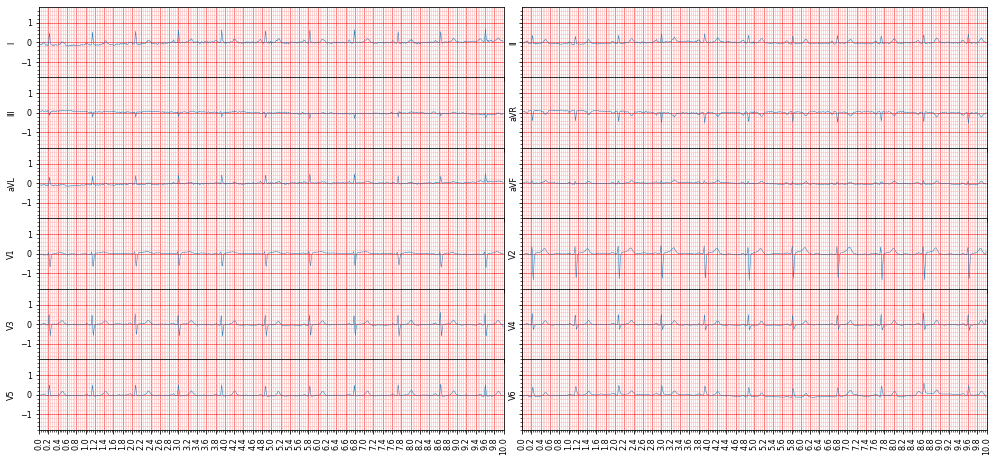

In [16]:
ecg_plot.plot_12(raw_signals[0].T, sample_rate=100, title='')
ecg_plot.show()

<a id=part-2-2-1-exploring-the-meta-data></a>

### Part 2.2.1: Exploring the meta-data

Let's explore the classes and establish a baseline of model accuracy if we just guess the majority class

In [17]:
#Doing a count
meta_data_df['diagnostic_superclass'].value_counts()

NORM       9083
STTC       5250
CD         3838
MI         2538
HYP         721
NO_DIAG     407
Name: diagnostic_superclass, dtype: int64

In [18]:
#Get the mean of the value counts
meta_data_df['diagnostic_superclass'].value_counts().mean()

3639.5

In [19]:
#Get the percentage of the value counts
meta_data_df['diagnostic_superclass'].value_counts(normalize=True)*100

NORM       41.594541
STTC       24.041764
CD         17.575674
MI         11.622476
HYP         3.301736
NO_DIAG     1.863809
Name: diagnostic_superclass, dtype: float64

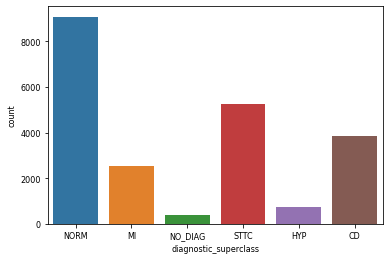

In [20]:
#Plotting the counts
sns.countplot(x = meta_data_df['diagnostic_superclass']);

It seems there is twice as many NORM heartbeats as the second most frequent class, STTC. MI follows closely behind, and there are even fewer NO_DIAG, HYP, and CD.

Put another way, there are 3 classes that are higher than the mean and 3 others that are way below the mean. NORM has about 2.5 times as many counts as the mean, while STTC and MI are about 1.4x as much. All this shows there's a severe imbalance in classes.

If we were to predict the majority class, NORM, we would be right 43.63% of the time.

In [22]:
meta_data_df.describe()

,patient_id,age,sex,height,weight,nurse,site,validated_by,strat_fold,CD,HYP,MI,NORM,NO_DIAG,STTC
count,21837.000000,21748.000000,21837.000000,6983.000000,9429.000000,20328.000000,21819.000000,12426.000000,21837.000000,21837.000000,21837.000000,21837.000000,21837.000000,21837.000000,21837.000000
mean,11255.005953,59.836307,0.478912,166.708292,70.997561,2.292503,1.547229,0.747948,5.505335,0.175757,0.033017,0.116225,0.415945,0.018638,0.240418
std,6234.132489,16.953125,0.499567,10.864935,15.875146,3.254786,4.169753,1.183269,2.875306,0.380622,0.178686,0.320502,0.492895,0.135246,0.427347
min,302.000000,2.000000,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5982.000000,50.000000,0.000000,160.000000,60.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11423.000000,62.000000,0.000000,166.000000,70.000000,1.000000,1.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16614.000000,72.000000,1.000000,174.000000,80.000000,3.000000,2.000000,1.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,21797.000000,95.000000,1.000000,209.000000,250.000000,11.000000,50.000000,11.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Saving meta_data for use in feature_engineering and data analysis

In [23]:
meta_data_df.to_csv('../data/data_analysis_files/meta_data_df.csv', index=False)

In [21]:
#Convert the diagnostic superclass into one hot encoded variables so that it can be used as input for labelling
#later in the MTEX-CNN architecture. Do not drop any columns here.
ohe = pd.get_dummies(meta_data_df['diagnostic_superclass'])
meta_data_df = pd.concat([meta_data_df, ohe], axis=1)
meta_data_df.to_csv('../data/features_df_folder/meta_data_df.csv')

<a id=part-2-2-2-exploring-ecg-data></a>

### Part 2.2.2: Exploring ECG data

In [24]:
#Save the first ecg signal in a variable for easy usage
ecg_sample = signals_df.iloc[0:1000,1]

<a id=part-2-2-2-1-decomposing-the-ecg-data></a>

#### Part 2.2.2.1: Decomposing the ecg data

##### Calculating Trend, Seasonality, and Residuals

In [26]:
#Using statsmodel's seasonal_decompose function. The sampling rate is 100, representing 1 second for every 100 samples
decomposition = seasonal_decompose(ecg_sample, model='additive', period=100)

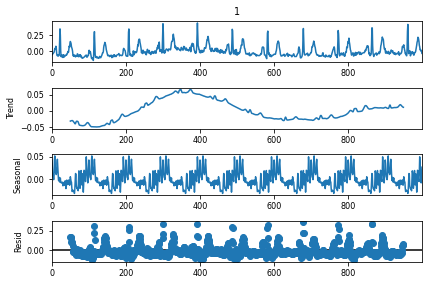

In [27]:
#Plotting the decomposition
decomposition.plot();

There is a cyclic trend in the ecg, which is as expected.

Seasonality seems to occur every second or so, which means this ecg shows approximately 1 heartbeat per 100 samples (1 second). 

<a id=part-2-2-2-2-calculating-stationarity></a>

#### Part 2.2.2.2: Calculating stationarity

Let's run an augmented dickey-fuller test to test for stationarity. The null hypothesis is that the signal has something called a 'unit root' and is not stationary. The alternate hypothesis is that the signal does not have a unit root and that the signal is stationary.

In [28]:
#Getting the values
X = ecg_sample.values

#Running an augmented dickey fuller test from Statsmodel
result = adfuller(X)

#Printing the results of the statistics
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
	print(f'{key}: {value}')

ADF Statistic: -4.646806316920628
p-value: 0.00010580297655267099
Critical Values:
1%: -3.43706091543889
5%: -2.8645028204932483
10%: -2.568347558984588


Now let's do multiple testing with the Augmented Dickey-Fuller test. Let's use the Bonferonni correction to check the values.

The p value is less that 0.05. This means that we can reject the null hypothesis. This means that the signal is very likely to be stationary.

Let's do multiple tests to get the stationarity for each ecg. First, use a function found online to quickly extract the ad fuller results. Then, use a custom function to apply the adf for each ecg per channel.

In [29]:
def adf(ts):
    """
    Augmented Dickey-Fuller unit root test
    """
    # make sure we are working with an array, convert if necessary
    
    ts = np.asarray(ts)    
    
    #Get the dimension of the array
    
    nobs = ts.shape[0]    
    
    # We use 1 as maximum lag in our calculations
    
    maxlag = 1    
    
    # Calculate the discrete difference
    
    tsdiff = np.diff(ts)    
    
    # Create a 2d array of lags, trim invalid observations on both sides
    
    tsdall = lagmat(tsdiff[:, None], maxlag, trim='both', original='in') # Get dimension of the array
    
    nobs = tsdall.shape[0]     
    
    # replace 0 xdiff with level of x
    
    tsdall[:, 0] = ts[-nobs - 1:-1]  
    
    tsdshort = tsdiff[-nobs:]    
    
    # Calculate the linear regression using an ordinary least squares model  
    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    
    adfstat = results.tvalues[0]    
    
    # Get approx p-value from a precomputed table (from stattools)
    
    pvalue = mackinnonp(adfstat, 'c', N=1)
    
    return pvalue

In [30]:
def adf_on_samples(dataframe):
    """
    Input: A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading.
    Output: A dataframe with 21837 rows and 12 columns, with each row being one ecg and each column being a lead
    of the ecg reading. Values in this dataframe will be the augmented dickey-fuller test values per channel per ecg.
    """
    output_df = pd.DataFrame(data=None)
    
    # For each of the 12-leads, do...
    for i in range(12):
    
        # Convert the dataframe into a (1000,21837) dataframe, with each column being 1 ecg for the 1000 time steps
        changed_df = pd.DataFrame(signals_df.iloc[:,i].values.reshape(21837,1000)).T
        
        #Apply the adfuller 
        functioned_df = changed_df.apply(lambda ts: adf(ts))
        
        #Turn the above output_array into a dataframe for concatenation
        df_for_appending = pd.DataFrame(functioned_df)
        
        #Concatenate df_for_appending to the output_df
        output_df = pd.concat([output_df, df_for_appending], axis=1)
    
    #Rename columns with lead number
    output_df.columns = [0,1,2,3,4,5,6,7,8,9,10,11]
    
    return output_df

In [31]:
#Load above multiple_adf_df csv

multiple_adf_df = pd.read_csv('../data/data_analysis_files/multiple_adf_df')
multiple_adf_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.458030e-28,3.794934e-28,1.817661e-16,4.885455e-29,8.440071e-26,2.955643e-15,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.879186e-28
1,2.482578e-22,4.443177e-18,2.132422e-08,1.151911e-21,1.090677e-06,6.385464e-14,0.000000e+00,0.0,2.815359e-29,2.061783e-30,0.000000e+00,2.976601e-30
2,0.000000e+00,4.575573e-17,5.434899e-05,1.188245e-28,2.054936e-25,5.912630e-03,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.485784e-30,2.332147e-28
3,0.000000e+00,5.176735e-19,1.591681e-12,7.376688e-26,6.643950e-14,3.551046e-15,2.480779e-25,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2.354896e-30,3.297436e-26,5.016413e-25,1.392117e-27,3.094876e-26,1.734445e-25,0.000000e+00,0.0,2.183346e-30,0.000000e+00,0.000000e+00,0.000000e+00


In [32]:
#If all the ecgs were stationary, we would expect n number of rejectable hypotheses

21836 * 12

262032

In [33]:
#Initialise the number of hypotheses available
rejectable_hypotheses = 0
unrejectable_hypotheses = 0 


for i in range(12):
    
    #Run multipletests on the p values
    multiple_tests_booleans = multipletests(multiple_adf_df.iloc[:,i], method = 'bonferroni')[0]
    
    #Convert the np.array boolens to a list
    multiple_tests_booleans = multiple_tests_booleans.tolist()
    
    #Sum the number of true and false booleans
    
    rejectable_hypotheses += multiple_tests_booleans.count(True)
    unrejectable_hypotheses += multiple_tests_booleans.count(False)
    
    print(f"Lead no. {i}, Rejectable hypotheses (no. of stationary ecgs): {multiple_tests_booleans.count(True)}")
    print(f"Lead no. {i}, Unrejectable hypotheses (no. of non-stationary ecgs): {multiple_tests_booleans.count(False)}")
    print('')
    
print(f"Total Rejectable hypotheses (no. of stationary ecgs): {rejectable_hypotheses}")
print(f"Total Unrejectable hypotheses (no. of non-stationary ecgs): {unrejectable_hypotheses}")

Lead no. 0, Rejectable hypotheses (no. of stationary ecgs): 21724
Lead no. 0, Unrejectable hypotheses (no. of non-stationary ecgs): 113

Lead no. 1, Rejectable hypotheses (no. of stationary ecgs): 21646
Lead no. 1, Unrejectable hypotheses (no. of non-stationary ecgs): 191

Lead no. 2, Rejectable hypotheses (no. of stationary ecgs): 21168
Lead no. 2, Unrejectable hypotheses (no. of non-stationary ecgs): 669

Lead no. 3, Rejectable hypotheses (no. of stationary ecgs): 21760
Lead no. 3, Unrejectable hypotheses (no. of non-stationary ecgs): 77

Lead no. 4, Rejectable hypotheses (no. of stationary ecgs): 21377
Lead no. 4, Unrejectable hypotheses (no. of non-stationary ecgs): 460

Lead no. 5, Rejectable hypotheses (no. of stationary ecgs): 21263
Lead no. 5, Unrejectable hypotheses (no. of non-stationary ecgs): 574

Lead no. 6, Rejectable hypotheses (no. of stationary ecgs): 21497
Lead no. 6, Unrejectable hypotheses (no. of non-stationary ecgs): 340

Lead no. 7, Rejectable hypotheses (no. of 

In [34]:
changed_df = pd.DataFrame(signals_df.iloc[:,0].values.reshape(21837,1000)).T

Leads no. 2, 4, and 5, and 11 have the most number of non-stationary ecgs with a bonferroni coefficient multiple hypotheses test, alpha = 0.05. We would expect to have the same number of non-stationary ecg signals in all the channels for a given ecg. However, the numbers differ. There could be something about how the above leads are measured that result in non-stationarity.

It could also be false negatives. Bonferroni is known for given a higher number of false negatives than is expected.

<a id=part-2-2-2-3-finding-the-amplitude-of-the-ecgs></a>

#### Part 2.2.2.3: Finding the amplitude of the ecgs

Each ecg plot is divided into multiple small squares. 5x5 small squares give a big sqare. Each small square is 0.1 mV and 1 mm tall/wide, while each big square is 0.5 mV and 5 mm tall/wide. Ecg voltage is calculated using the maximum-to-minimum peaks of the QRS complex to get the height. These heights are then multiplied by the number of small squares.

For our purposes, the amplitude of the signal will be sufficient as representation for voltage.

In [35]:
#Find the maximum peaks' indexes
sample_max, _ = signal.find_peaks(ecg_sample, distance= 90)

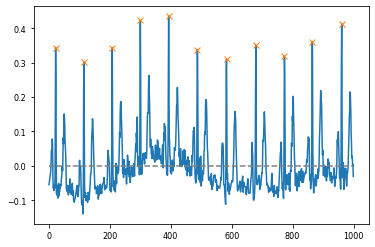

In [36]:
#Plot the peaks
plt.plot(ecg_sample)
plt.plot(sample_max, ecg_sample[sample_max], "x")
plt.plot(np.zeros_like(ecg_sample), "--", color="gray")
plt.show()

In [37]:
#Find the values of the maximum peaks
ecg_sample[sample_max]

22     0.344
115    0.302
208    0.343
300    0.423
393    0.435
487    0.338
583    0.310
679    0.350
773    0.319
864    0.361
961    0.413
Name: 1, dtype: float64

Let's find the inverse peaks of the same signal

In [38]:
#Invert signal
ecg_sample_inverted = ecg_sample * -1

In [39]:
#Find the minimum peaks' indexes
sample_min, _ = signal.find_peaks(ecg_sample_inverted, distance=90)

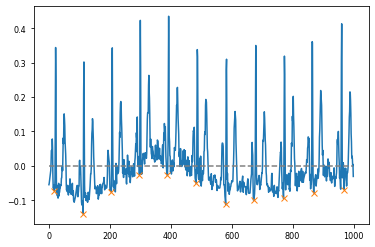

In [40]:
#Plot the minimum peaks
plt.plot(ecg_sample)
plt.plot(sample_min, ecg_sample[sample_min], "x")
plt.plot(np.zeros_like(ecg_sample), "--", color="gray")
plt.show()

In [41]:
#Find the values of the minimum peaks
ecg_sample[sample_min]

17    -0.072
112   -0.140
204   -0.076
297   -0.026
389   -0.028
482   -0.050
580   -0.112
672   -0.100
770   -0.095
869   -0.079
968   -0.069
Name: 1, dtype: float64

<a id=part-2-2-2-4-visualising-the-ecg-signal-in-the-frequency-domain></a>

#### Part 2.2.2.4: Visualising the ecg signal in the frequency-domain

Let's do a fast-fourier transform to convert the data from time-domain to frequency-domain for analysis

In [42]:
#Settings
sample_rate = 100

#N refers to the number of data points. In this case, 10 seconds sampled at 100, giving us 1000
N = 10 * sample_rate

#For the X-axis for plotting
time = np.linspace(0, 10, N)

#Set the X and y values for plotting later
#Nyquist frequency means we can only sample at a rate of 50Hz rather than the original 100
frequency = np.linspace (0.0, 50, int (N/2))



In [43]:
#Do fft on the ecg_sample
freq_data = fft(ecg_sample.values)

#Calculate the y values using freq_data
y = 2/N * np.abs (freq_data [0:np.int(N/2)])

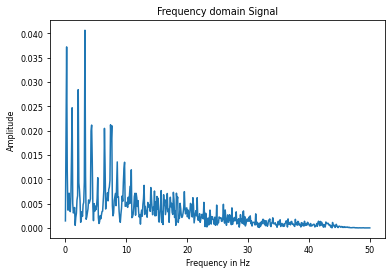

In [44]:
#Plotting the fft results
plt.plot(frequency, y)
plt.title('Frequency domain Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.show()

A lot of the frequencies are found in the lower end. It seems the higher frequency data could be noise, so a filter could be used to filter frequencies above 15Hz or so.

In [45]:
#Initialise Daubechies wavelet
w = pywt.Wavelet('db1')
#cA stands for Approximation coefficients, which are the low frequencies
#cD stands for Detail coefficients, which are the high frequencies
cA, cD = pywt.dwt(ecg_sample, wavelet=w, mode='constant')

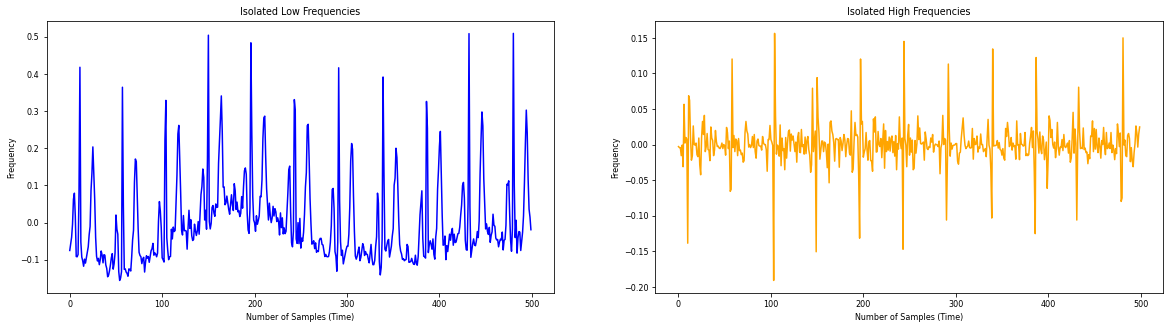

In [46]:
#Plot the figures
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(cA, color='blue')
ax[0].set_xlabel('Number of Samples (Time)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Isolated Low Frequencies')

ax[1].plot(cD, color='orange')
ax[1].set_xlabel('Number of Samples (Time)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Isolated High Frequencies')

plt.show()

The low frequency's shape (Blue line) is similar to the ECG sample. We can see the cyclic trend in this graph. The high frequencies (Orange line) seem to have the strongest signal every 50 samples or so, corresponding to one cycle in the low frequencies.

<a id=part-2-2-2-5-visualising-the-p-wave-qrs-complex-t-wave-and-rr-peaks-of-a-typical-ecg></a>

#### Part 2.2.2.5: Visualising the P wave, QRS complex, T wave, and RR peaks of a typical ecg

##### Getting R-peaks

Let's detect the R-peaks. R-peaks are best detected from lead 2, which is column 1 in the dataframe.

In [47]:
_, r_peaks = nk.ecg_peaks(ecg_sample, sampling_rate=100)

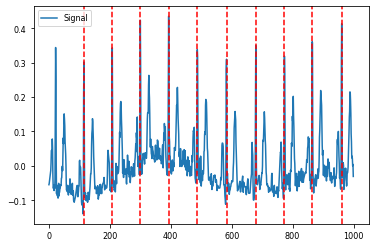

In [48]:
plot = nk.events_plot(r_peaks['ECG_R_Peaks'], ecg_sample)

It's hard to see, but the algorithm has indeed found the R-peaks. Notice that the red dotted lines each overlap with long, thin blue lines that indicate the R peaks.

##### Detecting P, Q, R, S, and T peaks

nk.events_plot allows us to plot where the P, Q, S, and T peaks are

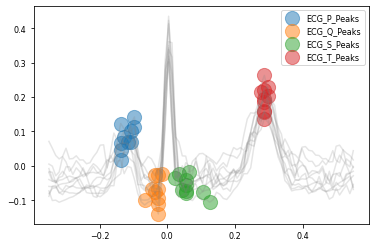

In [49]:
_, waves_peak = nk.ecg_delineate(ecg_sample, r_peaks, sampling_rate=100, show=True, show_type='peaks')

Notice that each peak is approximately in the same position, barring perhaps 2 of the S-peaks that are off-position.

Let's get an alternative way of visualising these peaks

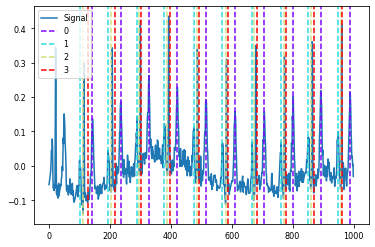

In [50]:
plot = nk.events_plot([waves_peak['ECG_T_Peaks'],
                       waves_peak['ECG_P_Peaks'],
                       waves_peak['ECG_Q_Peaks'],
                       waves_peak['ECG_S_Peaks']], ecg_sample)

This is quite hard to read. Let's zoom in to 3 of them

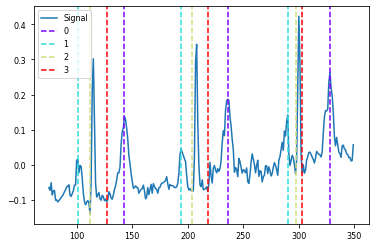

In [51]:
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3],
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], signals_df.iloc[75:350,1])

The teal line is the P-wave, the yellow line is the Q-peak, the red line is the S-peak, and the purple line is the T-peak.

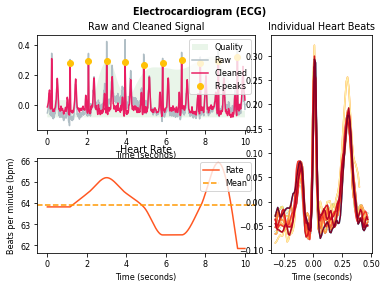

In [52]:
ecg_signal, info = nk.ecg_process(ecg_sample, sampling_rate=100)
plot = nk.ecg_plot(ecg_signal, sampling_rate=100)

<a id=part-2-2-2-6-getting-heart-rate-variability></a>

#### Part 2.2.2.6: Getting Heart Rate Variability (HRV)

Let's clean the ecgs with nk.ecg_clean in preparation to find peaks and get the heart rate variability

In [54]:
#Define a function for nk functions that output a dataframe
def nk_func_on_ecg(dataframe, function_name):
    """
    Input: 
    
    1. A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading.
    
    2. A string with the name of the neurokit function used, without the 'nk' prefix. e.g. use 'ecg_clean' to use
    nk.ecg_clean on the dataframe.
    
    Output: A dataframe with 21837000 rows and 12 columns, with each row being one ecg value at a time step, and a
    column being one ecg lead.
    """
    
    #Initialise the empty output_df
    output_df = pd.DataFrame(data=None)
    
    for i in range(12):
        array = getattr(nk, function_name)(dataframe.iloc[:,i], sampling_rate=100)
        
        #Turn the above output_array into a dataframe for concatenation
        df_for_appending = pd.DataFrame(array)
        
        #Concatenate df_for_appending to the output_df
        output_df = pd.concat([output_df, df_for_appending], axis=1)
        
    #Rename columns with lead number
    output_df.columns = [0,1,2,3,4,5,6,7,8,9,10,11]
    
    return output_df

In [55]:
#Let's get some cleaned signals for use later
cleaned_signals_df = nk_func_on_ecg(signals_df, 'ecg_clean')

In [56]:
#Define a function for nk functions that output a dataframe of 1s and 0s and a dictionary of samples
def nk_df_and_samples(dataframe, function_name):
    """
    Input: 
    
    1. A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading.
    
    2. A string with the name of the neurokit function used, without the 'nk' prefix. e.g. use 'ecg_delineate' to use
    nk.ecg_delineate on the dataframe.
    
    Output: A dataframe with 21837000 rows and 12 columns, with each row being one ecg value at a time step, and a
    column being one ecg lead.
    """
    
    #Initialise the empty output_df
    output_df = pd.DataFrame(data=None)
    
    for i in range(12):
        df_and_dict = getattr(nk, function_name)(dataframe.iloc[:,i], sampling_rate=100)
        
        #Turn the above output_array into a dataframe for concatenation
        df_for_appending = pd.DataFrame(df_and_dict[0])
        
        #Concatenate df_for_appending to the output_df
        output_df = pd.concat([output_df, df_for_appending], axis=1)
        
    #Rename columns with lead number
    output_df.columns = [f'{function_name}_0,{function_name}_1,{function_name}_2,{function_name}_3,\
                        {function_name}_4,{function_name}_5, {function_name}_6,{function_name}_7,\
                        {function_name}_8,{function_name}_9,{function_name}_10,{function_name}_11']
    
    return output_df

In [57]:
#Define a function for heart rate variability that output a dataframe
def hrv(dataframe):
    """
    Input: A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading.
    Output: A dataframe with 11 rows and 14 columns, with each row being summary values of heart rate variability, 
    and a column being a statistic for heart rate variability.
    """
    
    #Initialise the empty output_df
    output_df = pd.DataFrame(data=None)
    
    for i in range(12):
        channel_summary = nk.hrv_time(dataframe.iloc[:,i], sampling_rate=100)
        
        #Concatenate the channel heart rate variability to the output_df, concatenated on the row axis
        output_df = pd.concat([output_df, channel_summary], axis=0)
    
    output_df.index = [0,1,2,3,4,5,6,7,8,9,10,11,]
    
    return output_df

Let's get the heart rate variability information

In [59]:
hrv(cleaned_signals_df)

,HRV_RMSSD,HRV_MeanNN,HRV_SDNN,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_pNN50,HRV_pNN20,HRV_TINN,HRV_HTI
0,0.611698,-3.090121e-08,0.680571,0.611698,-2.202410e+07,-1.979528e+07,0.005921,0.127519,21.537962,0.172022,0.000000,0.000027,67.006111,179.854211
1,0.616956,-3.367274e-08,0.684130,0.616956,-2.031703e+07,-1.832211e+07,0.007266,0.122952,16.921242,0.165860,0.000000,0.000027,48.292606,124.502543
2,0.510828,-2.666629e-09,0.596276,0.510828,-2.236066e+08,-1.915633e+08,0.000040,0.093923,2344.734538,0.126714,0.000000,0.000009,59.617473,132.732383
3,0.558773,3.227895e-08,0.613830,0.558773,1.901641e+07,1.731076e+07,-0.007241,0.116332,-16.065951,0.156967,0.000000,0.000005,49.279873,188.146187
4,0.471564,-1.403423e-08,0.540624,0.471564,-3.852182e+07,-3.360099e+07,0.002119,0.092741,43.771355,0.125092,0.000000,0.000009,60.226112,196.549108
5,0.476772,-1.815449e-08,0.543939,0.476772,-2.996170e+07,-2.626191e+07,0.003715,0.092879,24.999155,0.125290,0.000000,0.000009,50.545006,189.294374
6,0.679437,4.126442e-08,0.834104,0.679437,2.021363e+07,1.646545e+07,0.001683,0.081822,48.629784,0.111082,0.000000,0.000110,125.986699,100.002743
7,1.086779,-3.280476e-09,1.284573,1.086779,-3.915814e+08,-3.312872e+08,0.006296,0.120380,19.120894,0.171492,0.000000,0.000627,86.919535,97.103391
8,1.188415,-3.594655e-08,1.323079,1.188415,-3.680683e+07,-3.306062e+07,0.008227,0.131415,15.972918,0.187660,0.000000,0.001145,114.535997,100.227650
9,1.315198,-5.815146e-08,1.374903,1.315198,-2.364348e+07,-2.261677e+07,0.009332,0.115995,12.429773,0.161278,0.000000,0.003961,94.783254,105.953930


The meaning of the heart rate variability summary is described below, taken from the [Neurokit2 documentation](https://neurokit2.readthedocs.io/en/latest/functions.html?highlight=heartbeat#module-neurokit2.hrv). The specific function used is 'hrv_time'.

1. RMSSD: The square root of the mean of the sum of successive differences between adjacent RR intervals. It is equivalent (although on another scale) to SD1, and therefore it is redundant to report correlations with both (Ciccone, 2017).


2. MeanNN: The mean of the RR intervals.


3. SDNN: The standard deviation of the RR intervals.


4. SDSD: The standard deviation of the successive differences between RR intervals.


5. CVNN: The standard deviation of the RR intervals (SDNN) divided by the mean of the RR intervals (MeanNN).


6. CVSD: The root mean square of the sum of successive differences (RMSSD) divided by the mean of the RR intervals (MeanNN).


7. MedianNN: The median of the absolute values of the successive differences between RR intervals.


8. MadNN: The median absolute deviation of the RR intervals.


9. HCVNN (Perhaps this is what MCVNN is supposed to be?): The median absolute deviation of the RR intervals (MadNN) divided by the median of the absolute differences of their successive differences (MedianNN).


10. IQRNN: The interquartile range (IQR) of the RR intervals.


11. pNN50: The proportion of RR intervals greater than 50ms, out of the total number of RR intervals.


12. pNN20: The proportion of RR intervals greater than 20ms, out of the total number of RR intervals.


13. TINN: A geometrical parameter of the HRV, or more specifically, the baseline width of the RR intervals distribution obtained by triangular interpolation, where the error of least squares determines the triangle. It is an approximation of the RR interval distribution.


14. HTI: The HRV triangular index, measuring the total number of RR intervals divded by the height of the RR intervals histogram.